# Generative Models
***

**ITMO University, Autumn 2022, MSc course**


## Assignment 1

***


*Authored by Arip Asadulaev & Manh Lab*

*Adapted by Alexander Panfilov*

***


The assignment is split into two parts: at first, you will implement classical GAN for the MNIST dataset, and after, you will enhance your results with DCGAN and the CIFAR10 dataset. 

Good luck!

## 1. GAN
*Source: <a href="https://arxiv.org/pdf/1406.2661.pdf" target="_blank">Goodfellow, Ian J., et al. "Generative Adversarial Networks." arXiv preprint arXiv:1406.2661 (2014)</a>.*

In 2014, Ian Goodfellow and his colleagues at the University of Montreal published a stunning paper introducing the world to GANs, or generative adversarial networks. The models play two distinct (literally, adversarial) roles. Given some real data set $\mathcal{X}$, $G$ is the generator, trying to create fake data that looks just like the genuine data, while $D$ is the discriminator, getting data from either the real set or $G$ and labeling the difference.

Goodfellow’s metaphor (and a fine one it is) was that $G$ was like a team of forgers trying to match real paintings with their output, while $D$ was the team of detectives trying to tell the difference. (Except in this case, the forgers $G$ never get to see the original data — only the judgments of $D$. They’re like blind forgers.)

<img src="https://production-media.paperswithcode.com/methods/gan.jpeg" style="display=block; margin:auto"/>
<p style="text-align: center">
    <b>Picture taken from the <a href="https://paperswithcode.com/method/gan" target="_blank">paperswithcode</a> website. There you can find a whole bunch of papers on GANs with implementation.</b>
</p>

In this part, we are going to implement classical GAN. You can find a rough plan on how to do it below; however, it is not mandatory to stick with it precisely but one might expect some questions related to the listed steps. Feel free to adapt provided code!

- Define the parameters
- Load the data (with transforms and normalization)
- Denormalize for visual inspection of samples
- Define the Discriminator network, the Generator network
- Study the activation function: Leaky ReLU
- Explain the output activation function: Tanh, Sigmoid
- Look at some sample outputs
- Define losses, optimizers and helper functions for training
     - For Discriminator
     - For Generator
- Train the model
- Save intermediate generated images to file
- Look at some outputs
- Save the models

### Imports

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms
from torchvision.datasets import CIFAR10, MNIST
from torchvision.transforms import Compose, Normalize, ToTensor
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

%matplotlib inline
plt.style.use("ggplot")

### Define parameters & data loading 

In [2]:
class GAN:
    hidden_size = 256
    batch_size = 100
    lr = 0.0002
    num_epochs = 150
    sample_dir = "./images/mnist"
    latent_size = 64
    n_channels = 1
    image_size = 28
    flat_image_size = n_channels * image_size * image_size
    device = "cuda" if torch.cuda.is_available() else "cpu"
    workers = 4
    seed = 2021

np.random.seed(GAN.seed)

if not os.path.exists(GAN.sample_dir):
    os.makedirs(GAN.sample_dir)

mnist_dataset = MNIST(
    root="data",
    train=True,
    download=True,
    transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]),
)

Label:  5


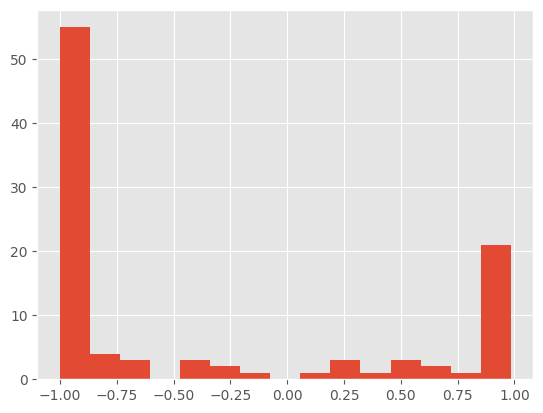

In [3]:
img, label = mnist_dataset[0]
print("Label: ", label)
plt.hist(img[:, 5:15, 5:15].flatten(), bins=15)
plt.show()

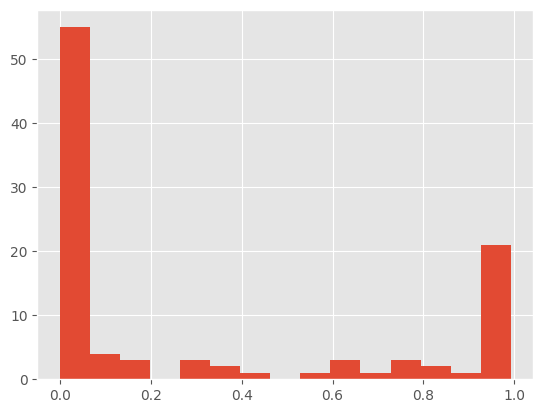

In [4]:
def denorm(x):
    return (x + 1) / 2

plt.hist(denorm(img[:, 5:15, 5:15]).flatten(), bins=15)
plt.show()

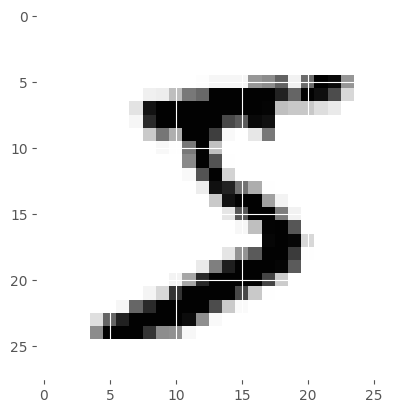

In [5]:
plt.imshow(denorm(img[0]), cmap='Greys')
plt.show()

In [6]:
data_loader = DataLoader(mnist_dataset, batch_size=GAN.batch_size, shuffle=True, num_workers=GAN.workers)

### GAN implementation

GAN consists of two deep networks, a generator ($G$) and a discriminator ($D$). The generator creates images before learning it. Since the discriminator is a binary classification model, we can use the binary cross-entropy loss function to quantify how well it can distinguish between real and generated images.

In [7]:
class Generator(nn.Module):
    def __init__(self, latent_size, image_size, hidden_size):
        super(Generator, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(latent_size, hidden_size, device=GAN.device),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size, device=GAN.device),
            nn.ReLU(),
            nn.Linear(hidden_size, image_size, device=GAN.device),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.seq(x)


class Discriminator(nn.Module):
    def __init__(self, image_size, hidden_size):
        super(Discriminator, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(image_size, hidden_size, device=GAN.device),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size, device=GAN.device),
            nn.ReLU(),
            nn.Linear(hidden_size, 1, device=GAN.device),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.seq(x)

### Create the Generator and Discriminator

In [8]:
G = Generator(GAN.latent_size, GAN.flat_image_size, GAN.hidden_size)
D = Discriminator(GAN.flat_image_size, GAN.hidden_size)

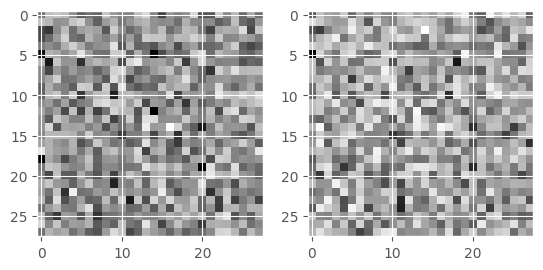

In [9]:
y = G(torch.randn(2, GAN.latent_size))
y = y.reshape(2, GAN.image_size, GAN.image_size).detach().numpy()
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.imshow(y[0], cmap='Greys')
ax2.imshow(y[1], cmap='Greys')
plt.show()

In [10]:
bce_loss = nn.BCELoss(reduction='mean')

g_adam_optim = torch.optim.Adam(G.parameters(), lr=GAN.lr)
d_adam_optim = torch.optim.Adam(D.parameters(), lr=GAN.lr)

Discriminator Training

In [11]:
def train_discriminator(
        d_model,
        d_optim,
        g_model,
        g_optim,
        z,
        loss_f,
        real_images,
        batch_size,
        device,
        eps=0.01
):
    noise1 = torch.Tensor(np.random.normal(0, 1, real_images.shape)).to(GAN.device)

    # Create the labels which are later used as input for the BCE loss
    real_labels = (torch.ones(batch_size, 1) * 0.9).to(device)
    fake_labels = (torch.ones(batch_size, 1) * 0.1).to(device)

    # Loss for real images
    real_score = d_model((1 - eps) * real_images + eps * noise1).reshape(batch_size, 1)
    real_loss = loss_f(real_score, real_labels)

    # Loss for fake images
    fake_images = g_model(z)
    noise2 = torch.Tensor(np.random.normal(0, 1, fake_images.shape)).to(GAN.device)
    fake_score = d_model((1 - eps) * fake_images + eps * noise2).reshape(batch_size, 1)
    fake_loss = loss_f(fake_score, fake_labels)

    # Sum losses
    d_loss = real_loss + fake_loss

    # Reset gradients
    d_optim.zero_grad()
    g_optim.zero_grad()

    # Compute gradients
    d_loss.backward()

    # Adjust the parameters using backprop
    d_optim.step()

    return d_loss, real_score, fake_score

Generator Training

In [12]:
def train_generator(
        d_model,
        d_optim,
        g_model,
        g_optim,
        loss_f,
        z,
        batch_size,
        device,
        eps=0.01
):
    # Generate fake images and calculate loss
    fake_images = g_model(z)
    noise = torch.Tensor(np.random.normal(0, 1, fake_images.shape)).to(GAN.device)
    fake_score = d_model((1 - eps) * fake_images + eps * noise).reshape(batch_size, 1)
    labels = (torch.ones(batch_size, 1) * 0.9).to(device)
    # calculate the generator loss
    g_loss = loss_f(fake_score, labels)

    # Reset gradients
    d_optim.zero_grad()
    g_optim.zero_grad()

    # Backprop and optimize
    g_loss.backward()
    g_optim.step()

    return g_loss, fake_images

### Start the training proccess

In [13]:
# function to save the sample output of generator
fixed_z = torch.Tensor(np.random.normal(0, 1, (64, GAN.latent_size))).to(GAN.device)
def save_fake_images_mnist(index):
    fake_images = G(fixed_z)
    fake_images = fake_images.reshape(64, GAN.n_channels, GAN.image_size, GAN.image_size)
    fake_fname = "fake_images-{0:0=4d}.png".format(index)
    print("Saving", fake_fname)
    save_image(denorm(fake_images), os.path.join(GAN.sample_dir, fake_fname), nrow=10)

In [14]:
%%time
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
G.to(GAN.device)
D.to(GAN.device)
for epoch in range(GAN.num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(GAN.batch_size, -1).to(GAN.device)
        z = torch.Tensor(np.random.normal(0, 1, (GAN.batch_size, GAN.latent_size))).to(GAN.device)

        # Train the discriminator
        d_loss, real_score, fake_score = train_discriminator(
            d_model=D,
            d_optim=d_adam_optim,
            g_model=G,
            g_optim=g_adam_optim,
            loss_f=bce_loss,
            z=z,
            real_images=images,
            batch_size=GAN.batch_size,
            device=GAN.device,
            eps=0
        )

        z = torch.Tensor(np.random.normal(0, 1, (GAN.batch_size, GAN.latent_size))).to(GAN.device)
        # Train the generator
        g_loss, fake_images = train_generator(
            d_model=D,
            d_optim=d_adam_optim,
            g_model=G,
            g_optim=g_adam_optim,
            loss_f=bce_loss,
            z=z,
            batch_size=GAN.batch_size,
            device=GAN.device,
            eps=0
        )

        # Inspect the losses
        if (i + 1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print(
                "Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}".format(
                    epoch + 1,
                    GAN.num_epochs,
                    i + 1,
                    total_step,
                    d_loss.item(),
                    g_loss.item(),
                    real_score.mean().item(),
                    fake_score.mean().item(),
                )
            )
    # Sample and save images
    save_fake_images_mnist(epoch + 1)

Epoch [1/150], Step [200/600], d_loss: 0.6934, g_loss: 1.8574, D(x): 0.89, D(G(z)): 0.16
Epoch [1/150], Step [400/600], d_loss: 0.7186, g_loss: 1.8894, D(x): 0.84, D(G(z)): 0.19
Epoch [1/150], Step [600/600], d_loss: 0.6878, g_loss: 2.5669, D(x): 0.89, D(G(z)): 0.14
Saving fake_images-0001.png
Epoch [2/150], Step [200/600], d_loss: 0.7791, g_loss: 2.0345, D(x): 0.77, D(G(z)): 0.14
Epoch [2/150], Step [400/600], d_loss: 0.7123, g_loss: 2.3698, D(x): 0.88, D(G(z)): 0.10
Epoch [2/150], Step [600/600], d_loss: 0.7152, g_loss: 2.4332, D(x): 0.90, D(G(z)): 0.08
Saving fake_images-0002.png
Epoch [3/150], Step [200/600], d_loss: 0.7364, g_loss: 2.1458, D(x): 0.90, D(G(z)): 0.12
Epoch [3/150], Step [400/600], d_loss: 0.6634, g_loss: 2.2888, D(x): 0.89, D(G(z)): 0.11
Epoch [3/150], Step [600/600], d_loss: 0.8469, g_loss: 1.8447, D(x): 0.85, D(G(z)): 0.28
Saving fake_images-0003.png
Epoch [4/150], Step [200/600], d_loss: 0.9235, g_loss: 1.4584, D(x): 0.76, D(G(z)): 0.29
Epoch [4/150], Step [400/6

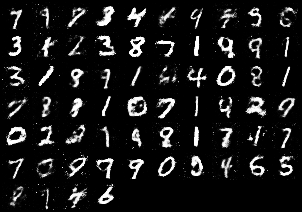

In [32]:
# show output after epochs training
Image.open(os.path.join(GAN.sample_dir, "fake_images-0150.png"))

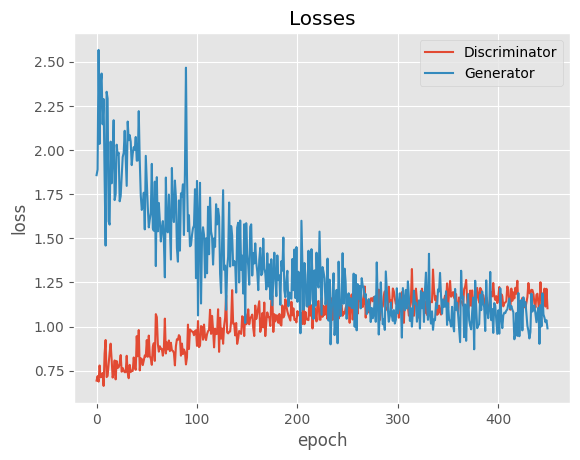

In [16]:
# show the discriminator loss and generator loss
plt.plot(d_losses, "-")
plt.plot(g_losses, "-")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Discriminator", "Generator"])
plt.title("Losses")
plt.show()

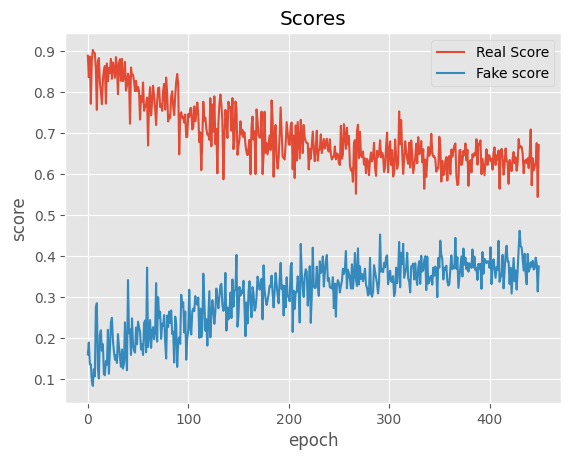

In [17]:
# plot the accuracy of discrimator
plt.plot(real_scores, "-")
plt.plot(fake_scores, "-")
plt.xlabel("epoch")
plt.ylabel("score")
plt.legend(["Real Score", "Fake score"])
plt.title("Scores")
plt.show()

## 2. DCGAN

*Source: <a href="https://arxiv.org/pdf/1511.06434v2.pdf" target="_blank">Radford, Alec, Luke Metz, and Soumith Chintala. "Unsupervised representation learning with deep convolutional generative adversarial networks." arXiv preprint arXiv:1511.06434 (2015)</a>.*

The goal of this part is to enhance your results achieved in the part one with DCGAN. Feel free to reuse your code, improve architecture or training scheme, etc.

In [54]:
class DCGAN:
    batch_size = 128
    num_epochs = 30
    workers = 4
    seed = 2021
    image_size = 64
    download = True
    dataroot = "data"
    n_channels = 3
    n_generator_features = 64
    latent_size = 100
    n_discriminator_features = 64
    lr = 0.0002
    device = "cuda" if torch.cuda.is_available() else "cpu"
    sample_dir = "./images/cifar"

np.random.seed(DCGAN.seed)

if not os.path.exists(DCGAN.sample_dir):
    os.makedirs(DCGAN.sample_dir)

cifar_dataset = CIFAR10(
    root=DCGAN.dataroot,
    download=DCGAN.download,
    transform=transforms.Compose(
        [
            transforms.Resize([DCGAN.image_size, DCGAN.image_size]),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
)

Files already downloaded and verified


Label:  6


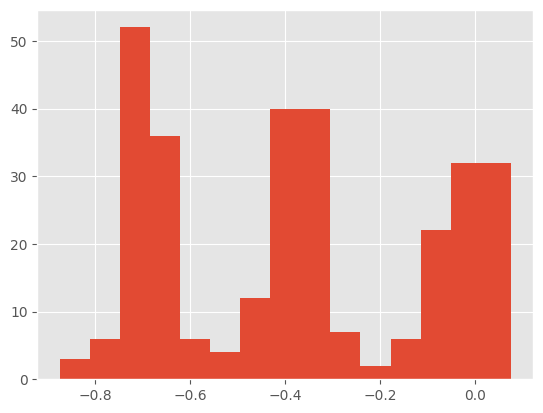

In [55]:
img, label = cifar_dataset[0]
print("Label: ", label)
plt.hist(img[:, 5:15, 5:15].flatten(), bins=15)
plt.show()

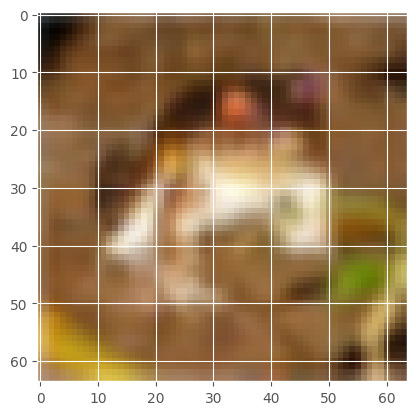

In [56]:
plt.imshow(np.transpose(denorm(img), (1, 2, 0)))
plt.show()

In [57]:
data_loader = DataLoader(cifar_dataset, batch_size=DCGAN.batch_size, shuffle=True, num_workers=DCGAN.workers)

### DCGAN implementation

In [58]:
class DCGenerator(nn.Module):
    def __init__(self, n_channels, latent_size, n_generator_features):
        super(DCGenerator, self).__init__()
        self.seq = nn.Sequential(
            nn.ConvTranspose2d(latent_size, n_generator_features * 8, kernel_size=4, bias=False),
            nn.BatchNorm2d(n_generator_features * 8),
            nn.ReLU(),
            nn.ConvTranspose2d(n_generator_features * 8, n_generator_features * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(n_generator_features * 4),
            nn.ReLU(),
            nn.ConvTranspose2d(n_generator_features * 4, n_generator_features * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(n_generator_features * 2),
            nn.ReLU(),
            nn.ConvTranspose2d(n_generator_features * 2, n_generator_features, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(n_generator_features),
            nn.ReLU(),
            nn.ConvTranspose2d(n_generator_features, n_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.seq(x)


class DCDiscriminator(nn.Module):
    def __init__(self, n_channels, n_discriminator_features):
        super(DCDiscriminator, self).__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(n_channels, n_discriminator_features, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2),
            nn.Conv2d(n_discriminator_features, n_discriminator_features * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(n_discriminator_features * 2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(n_discriminator_features * 2, n_discriminator_features * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(n_discriminator_features * 4),
            nn.LeakyReLU(0.2),
            nn.Conv2d(n_discriminator_features * 4, n_discriminator_features * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(n_discriminator_features * 8),
            nn.LeakyReLU(0.2),
            nn.Conv2d(n_discriminator_features * 8, 1, kernel_size=4, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.seq(x)

In [59]:
DCG = DCGenerator(DCGAN.n_channels, DCGAN.latent_size, DCGAN.n_generator_features)
DCD = DCDiscriminator(DCGAN.n_channels, DCGAN.n_discriminator_features)

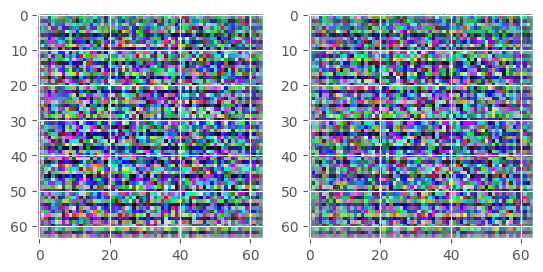

In [60]:
y = DCG(torch.randn(2, DCGAN.latent_size, 1, 1)).detach().numpy()
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.imshow(np.transpose(denorm(y[0]), (1, 2, 0)))
ax2.imshow(np.transpose(denorm(y[1]), (1, 2, 0)))
plt.show()

In [61]:
DCD(img[None])

tensor([[[[0.4648]]]], grad_fn=<SigmoidBackward0>)

In [62]:
dc_bce_loss = nn.BCELoss()

dcg_adam_optim = torch.optim.Adam(DCG.parameters(), lr=DCGAN.lr)
dcd_adam_optim = torch.optim.Adam(DCD.parameters(), lr=DCGAN.lr)

### Start the training proccess

In [63]:
fixed_z = torch.Tensor(np.random.normal(0, 1, (DCGAN.batch_size, DCGAN.latent_size, 1, 1))).to(DCGAN.device)
def save_fake_images_cifar(index):
    fake_images = DCG(fixed_z)
    fake_images = fake_images.reshape(DCGAN.batch_size, DCGAN.n_channels, DCGAN.image_size, DCGAN.image_size)
    fake_fname = "fake_images-{0:0=4d}.png".format(index)
    print("Saving", fake_fname)
    save_image(
        denorm(fake_images), os.path.join(DCGAN.sample_dir, fake_fname), nrow=10
    )

In [64]:
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
DCG.to(DCGAN.device)
DCD.to(DCGAN.device)

def train():
    for epoch in tqdm(range(DCGAN.num_epochs)):
        for i, (images, _) in tqdm(enumerate(data_loader)):
            if i == 390:
                continue
            # Load a batch & transform to vectors
            images = images.reshape(DCGAN.batch_size, DCGAN.n_channels, DCGAN.image_size, DCGAN.image_size).to(DCGAN.device)
            z = torch.Tensor(np.random.normal(0, 1, (DCGAN.batch_size, DCGAN.latent_size, 1, 1))).to(DCGAN.device)

            # Train the discriminator
            d_loss, real_score, fake_score = train_discriminator(
                d_model=DCD,
                d_optim=dcd_adam_optim,
                g_model=DCG,
                g_optim=dcg_adam_optim,
                z=z,
                loss_f=dc_bce_loss,
                real_images=images,
                batch_size=DCGAN.batch_size,
                device=DCGAN.device,
            )

            z = torch.Tensor(np.random.normal(0, 1, (DCGAN.batch_size, DCGAN.latent_size, 1, 1))).to(DCGAN.device)
            # Train the generator
            g_loss, fake_images = train_generator(
                d_model=DCD,
                d_optim=dcd_adam_optim,
                g_model=DCG,
                g_optim=dcg_adam_optim,
                z=z,
                loss_f=dc_bce_loss,
                batch_size=DCGAN.batch_size,
                device=DCGAN.device,
            )

            # Inspect the losses
            if (i + 1) % 130 == 0: # max(i) = 389
                d_losses.append(d_loss.item())
                g_losses.append(g_loss.item())
                real_scores.append(real_score.mean().item())
                fake_scores.append(fake_score.mean().item())
                print(
                    "Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}".format(
                        epoch + 1,
                        DCGAN.num_epochs,
                        i + 1,
                        total_step,
                        d_loss.item(),
                        g_loss.item(),
                        real_score.mean().item(),
                        fake_score.mean().item(),
                    )
            )
        # Sample and save images
        save_fake_images_cifar(epoch + 1)

In [65]:
%%time
train()

  0%|          | 0/30 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch [1/30], Step [130/391], d_loss: 0.6586, g_loss: 3.0729, D(x): 0.88, D(G(z)): 0.09
Epoch [1/30], Step [260/391], d_loss: 0.6614, g_loss: 2.2087, D(x): 0.88, D(G(z)): 0.10
Epoch [1/30], Step [390/391], d_loss: 0.6610, g_loss: 2.3355, D(x): 0.90, D(G(z)): 0.13
Saving fake_images-0001.png


0it [00:00, ?it/s]

Epoch [2/30], Step [130/391], d_loss: 0.6574, g_loss: 2.6163, D(x): 0.91, D(G(z)): 0.10
Epoch [2/30], Step [260/391], d_loss: 0.6674, g_loss: 2.8797, D(x): 0.87, D(G(z)): 0.08
Epoch [2/30], Step [390/391], d_loss: 0.6720, g_loss: 2.4092, D(x): 0.91, D(G(z)): 0.14
Saving fake_images-0002.png


0it [00:00, ?it/s]

Epoch [3/30], Step [130/391], d_loss: 0.7105, g_loss: 2.9687, D(x): 0.91, D(G(z)): 0.20
Epoch [3/30], Step [260/391], d_loss: 0.6671, g_loss: 2.5366, D(x): 0.87, D(G(z)): 0.09
Epoch [3/30], Step [390/391], d_loss: 0.6679, g_loss: 2.1038, D(x): 0.92, D(G(z)): 0.09
Saving fake_images-0003.png


0it [00:00, ?it/s]

Epoch [4/30], Step [130/391], d_loss: 0.7144, g_loss: 2.8120, D(x): 0.80, D(G(z)): 0.07
Epoch [4/30], Step [260/391], d_loss: 0.6797, g_loss: 2.3049, D(x): 0.85, D(G(z)): 0.10
Epoch [4/30], Step [390/391], d_loss: 0.6691, g_loss: 2.1230, D(x): 0.86, D(G(z)): 0.08
Saving fake_images-0004.png


0it [00:00, ?it/s]

Epoch [5/30], Step [130/391], d_loss: 0.6686, g_loss: 2.1605, D(x): 0.91, D(G(z)): 0.15
Epoch [5/30], Step [260/391], d_loss: 0.6775, g_loss: 2.0995, D(x): 0.83, D(G(z)): 0.09
Epoch [5/30], Step [390/391], d_loss: 0.6691, g_loss: 2.9872, D(x): 0.88, D(G(z)): 0.07
Saving fake_images-0005.png


0it [00:00, ?it/s]

Epoch [6/30], Step [130/391], d_loss: 0.6818, g_loss: 2.5244, D(x): 0.94, D(G(z)): 0.16
Epoch [6/30], Step [260/391], d_loss: 0.6906, g_loss: 1.9302, D(x): 0.90, D(G(z)): 0.18
Epoch [6/30], Step [390/391], d_loss: 0.6676, g_loss: 2.6435, D(x): 0.89, D(G(z)): 0.08
Saving fake_images-0006.png


0it [00:00, ?it/s]

Epoch [7/30], Step [130/391], d_loss: 0.6762, g_loss: 1.7333, D(x): 0.90, D(G(z)): 0.17
Epoch [7/30], Step [260/391], d_loss: 0.7163, g_loss: 2.1063, D(x): 0.92, D(G(z)): 0.22
Epoch [7/30], Step [390/391], d_loss: 0.6636, g_loss: 2.1879, D(x): 0.90, D(G(z)): 0.14
Saving fake_images-0007.png


0it [00:00, ?it/s]

Epoch [8/30], Step [130/391], d_loss: 0.7092, g_loss: 2.2810, D(x): 0.83, D(G(z)): 0.05
Epoch [8/30], Step [260/391], d_loss: 0.6745, g_loss: 2.7743, D(x): 0.93, D(G(z)): 0.14
Epoch [8/30], Step [390/391], d_loss: 0.6862, g_loss: 2.1441, D(x): 0.84, D(G(z)): 0.15
Saving fake_images-0008.png


0it [00:00, ?it/s]

Epoch [9/30], Step [130/391], d_loss: 0.6806, g_loss: 1.7998, D(x): 0.84, D(G(z)): 0.10
Epoch [9/30], Step [260/391], d_loss: 0.7162, g_loss: 2.3943, D(x): 0.86, D(G(z)): 0.21
Epoch [9/30], Step [390/391], d_loss: 0.6746, g_loss: 3.6772, D(x): 0.92, D(G(z)): 0.10
Saving fake_images-0009.png


0it [00:00, ?it/s]

Epoch [10/30], Step [130/391], d_loss: 0.6649, g_loss: 2.7815, D(x): 0.90, D(G(z)): 0.11
Epoch [10/30], Step [260/391], d_loss: 0.6983, g_loss: 2.8453, D(x): 0.81, D(G(z)): 0.07
Epoch [10/30], Step [390/391], d_loss: 0.6828, g_loss: 2.5074, D(x): 0.86, D(G(z)): 0.15
Saving fake_images-0010.png


0it [00:00, ?it/s]

Epoch [11/30], Step [130/391], d_loss: 0.6929, g_loss: 2.4670, D(x): 0.85, D(G(z)): 0.07
Epoch [11/30], Step [260/391], d_loss: 0.6722, g_loss: 1.7310, D(x): 0.90, D(G(z)): 0.11
Epoch [11/30], Step [390/391], d_loss: 0.6891, g_loss: 2.7600, D(x): 0.85, D(G(z)): 0.10
Saving fake_images-0011.png


0it [00:00, ?it/s]

Epoch [12/30], Step [130/391], d_loss: 0.7202, g_loss: 2.3560, D(x): 0.81, D(G(z)): 0.05
Epoch [12/30], Step [260/391], d_loss: 0.7146, g_loss: 2.0937, D(x): 0.94, D(G(z)): 0.21
Epoch [12/30], Step [390/391], d_loss: 0.6760, g_loss: 3.2452, D(x): 0.88, D(G(z)): 0.09
Saving fake_images-0012.png


0it [00:00, ?it/s]

Epoch [13/30], Step [130/391], d_loss: 0.7020, g_loss: 1.7801, D(x): 0.86, D(G(z)): 0.19
Epoch [13/30], Step [260/391], d_loss: 0.6697, g_loss: 2.5064, D(x): 0.86, D(G(z)): 0.10
Epoch [13/30], Step [390/391], d_loss: 0.6652, g_loss: 2.3778, D(x): 0.89, D(G(z)): 0.11
Saving fake_images-0013.png


0it [00:00, ?it/s]

Epoch [14/30], Step [130/391], d_loss: 0.7228, g_loss: 1.6340, D(x): 0.95, D(G(z)): 0.20
Epoch [14/30], Step [260/391], d_loss: 0.6786, g_loss: 2.5386, D(x): 0.84, D(G(z)): 0.09
Epoch [14/30], Step [390/391], d_loss: 0.6716, g_loss: 2.0392, D(x): 0.90, D(G(z)): 0.08
Saving fake_images-0014.png


0it [00:00, ?it/s]

Epoch [15/30], Step [130/391], d_loss: 0.7776, g_loss: 1.8285, D(x): 0.93, D(G(z)): 0.29
Epoch [15/30], Step [260/391], d_loss: 0.6787, g_loss: 2.4874, D(x): 0.91, D(G(z)): 0.15
Epoch [15/30], Step [390/391], d_loss: 0.6696, g_loss: 2.4118, D(x): 0.92, D(G(z)): 0.10
Saving fake_images-0015.png


0it [00:00, ?it/s]

Epoch [16/30], Step [130/391], d_loss: 0.6712, g_loss: 1.6126, D(x): 0.92, D(G(z)): 0.11
Epoch [16/30], Step [260/391], d_loss: 0.7192, g_loss: 2.8564, D(x): 0.81, D(G(z)): 0.17
Epoch [16/30], Step [390/391], d_loss: 0.7094, g_loss: 2.1183, D(x): 0.80, D(G(z)): 0.08
Saving fake_images-0016.png


0it [00:00, ?it/s]

Epoch [17/30], Step [130/391], d_loss: 0.7354, g_loss: 2.9599, D(x): 0.82, D(G(z)): 0.04
Epoch [17/30], Step [260/391], d_loss: 0.6832, g_loss: 2.5215, D(x): 0.84, D(G(z)): 0.12
Epoch [17/30], Step [390/391], d_loss: 0.7086, g_loss: 2.4642, D(x): 0.89, D(G(z)): 0.19
Saving fake_images-0017.png


0it [00:00, ?it/s]

Epoch [18/30], Step [130/391], d_loss: 0.7559, g_loss: 1.9916, D(x): 0.95, D(G(z)): 0.24
Epoch [18/30], Step [260/391], d_loss: 0.6803, g_loss: 2.2850, D(x): 0.85, D(G(z)): 0.10
Epoch [18/30], Step [390/391], d_loss: 0.6680, g_loss: 2.8562, D(x): 0.89, D(G(z)): 0.13
Saving fake_images-0018.png


0it [00:00, ?it/s]

Epoch [19/30], Step [130/391], d_loss: 0.6788, g_loss: 1.6741, D(x): 0.88, D(G(z)): 0.14
Epoch [19/30], Step [260/391], d_loss: 0.7031, g_loss: 2.6566, D(x): 0.81, D(G(z)): 0.08
Epoch [19/30], Step [390/391], d_loss: 0.7963, g_loss: 2.8079, D(x): 0.72, D(G(z)): 0.05
Saving fake_images-0019.png


0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x11d6178b0>
Traceback (most recent call last):
  File "/Users/alv.popov/study/ml/venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/Users/alv.popov/study/ml/venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1430, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/local/Cellar/python@3.9/3.9.13_1/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/usr/local/Cellar/python@3.9/3.9.13_1/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/local/Cellar/python@3.9/3.9.13_1/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/connection.py", line 936, in wait
    ready = sel

KeyboardInterrupt: 

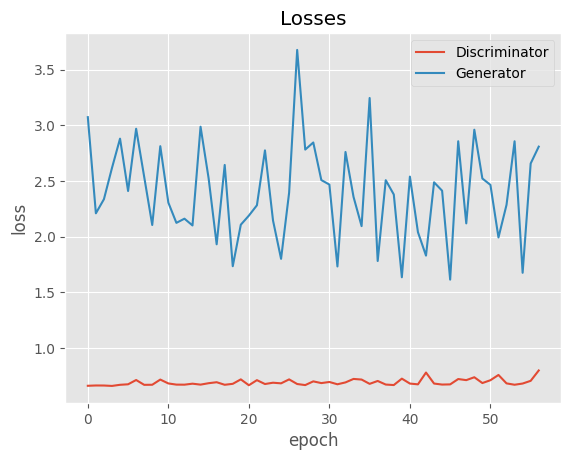

In [70]:
# show the discriminator loss and generator loss
plt.plot(d_losses, "-")
plt.plot(g_losses, "-")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Discriminator", "Generator"])
plt.title("Losses")
plt.show()

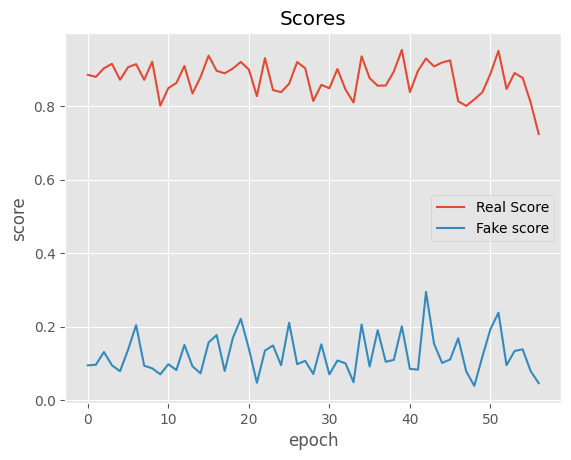

In [71]:
# plot the accuracy of discrimator
plt.plot(real_scores, "-")
plt.plot(fake_scores, "-")
plt.xlabel("epoch")
plt.ylabel("score")
plt.legend(["Real Score", "Fake score"])
plt.title("Scores")
plt.show()

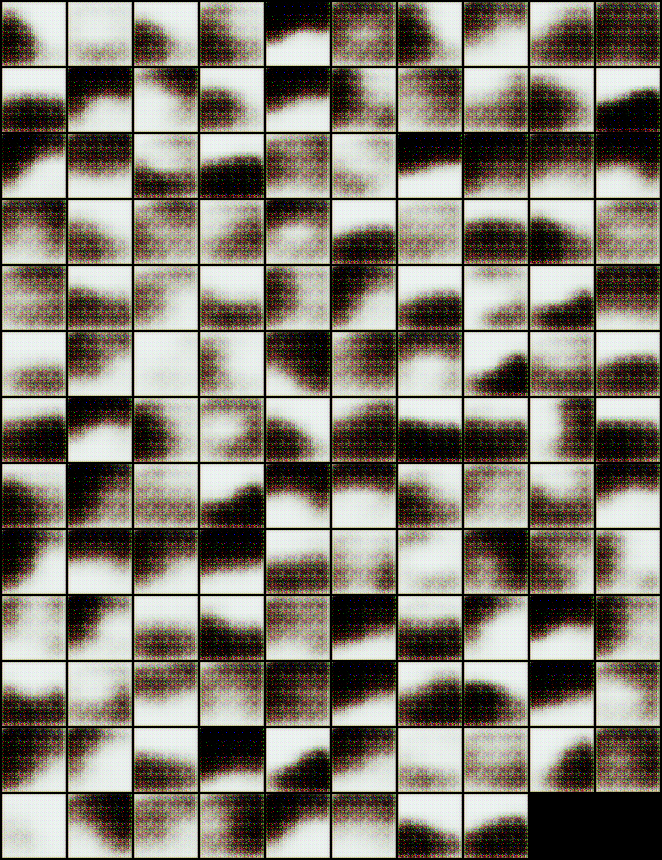

In [74]:
# show output after epochs training
Image.open(os.path.join(DCGAN.sample_dir, "fake_images-0001.png"))

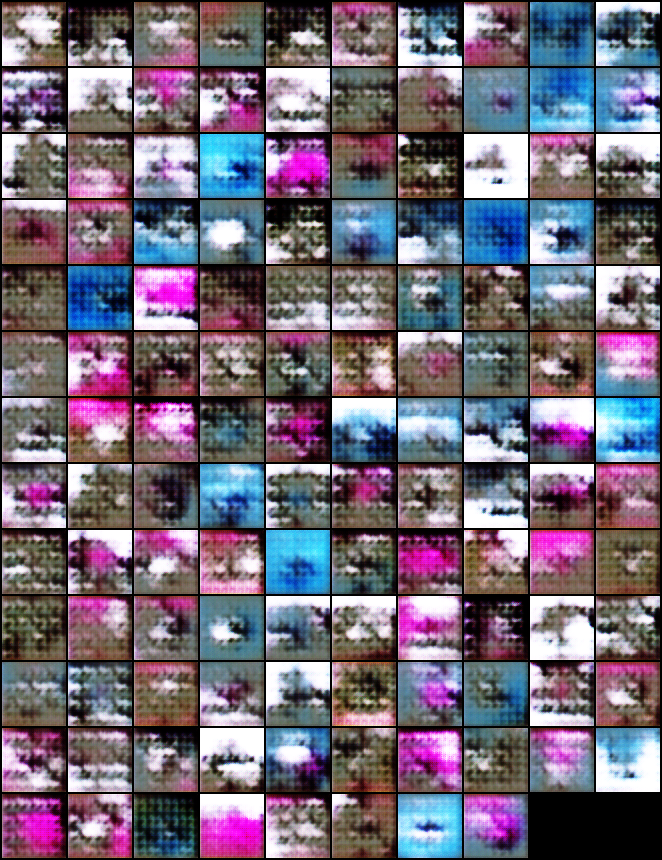

In [75]:
# show output after epochs training
Image.open(os.path.join(DCGAN.sample_dir, "fake_images-0018.png"))